<a href="https://colab.research.google.com/github/sarthak-srivastava/Learning-Iterative-Image-Reconstruction/blob/master/NNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to the paper: http://www.ais.uni-bonn.de/behnke/papers/ijcai01.pdf

In [1]:
#Lets get started by loading our basic dependencies
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
import argparse


In [2]:
from tqdm import tqdm
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/")

In [5]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
x_train = mnist.train.images[:55000,:]
x_train.shape

(55000, 784)

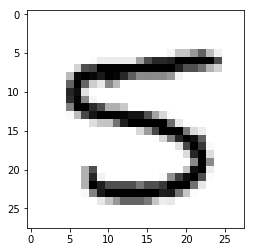

In [7]:
#Let's have a look at a random image
RandomNum = random.randint(0,55000)
image = x_train[RandomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [8]:
x =[0]*55000
image_label = [0]*55000
image_train = [0]*55000
for i in range(55000):
  x[i] = x_train[i].reshape([28,28])
  image_label[i] = x_train[i].reshape([784,1])
  image_train[i] = resize(x[i], (14,14))

 

/home/sarthak/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


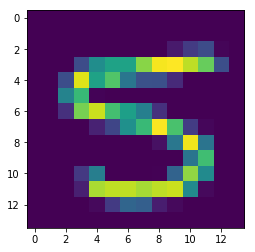

In [9]:
plt.imshow(image_train[RandomNum])
plt.show()

In [10]:
for i in range(55000):
  image_train[i] = image_train[i].reshape([196,1]) 

In [12]:
from itertools import product

from stackrnn import StackRNNCell, StackLSTMCell, RecurrentWrapper

In [15]:
parser = argparse.ArgumentParser(
    description = "Train model on algorithmic patterns")
parser.add_argument("model", type = str, default = None,
                    help = "rnn | lstm | srnn | slstm")
parser.add_argument("task", type = int, default = None,
                    help = "1 | 2 | 3 | 4 | 5")
parser.add_argument("n_symbols", type = int, default = None,
                    help = "number of symbols in alphabet")
parser.add_argument("-N", type = int, default = 10000 // 100, 
                    help = "number of iterations to train model",
                    dest = "n_iter")
parser.add_argument("-S", type = int, default = 100,
                    help = "number of sequences to train on per iteration",
                    dest = "n_seq_per_iter")

args = parser.parse_args()

# hyperparameter search on algorithmic patterns

n_iterations = args.n_iter
n_seq_per_iter = args.n_seq_per_iter

assert args.task in [1, 2, 3, 4, 5]
task = args.task
n_symbols = args.n_symbols
n_min = 2
n_max_train = 15
n_max_val = 19
n_max_test = 60

if args.model == "rnn" or args.model == "lstm":
    hidden_sizes = [50, 100, 200]
    hidden_layers = [1, 2]
    sgd_lrs = [0.1, 0.01, 0.001]
    n_stacks = [0]
    ks = [0]
elif args.model == "srnn" or args.model == "slstm":
    hidden_sizes = [20, 40, 100]
    hidden_layers = [1]
    sgd_lrs = [0.1, 0.01, 0.001]
    n_stacks = [1, 2, 5, 10]
    ks = [1, 2]
else:
    print(parser.print_help())
    sys.exit()



usage: ipykernel_launcher.py [-h] [-N N_ITER] [-S N_SEQ_PER_ITER]
                             model task n_symbols
ipykernel_launcher.py: error: the following arguments are required: task, n_symbols


SystemExit: 2

/home/sarthak/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [16]:
for hidden_size, n_layers, sgd_lr, n_stack, k in \
    product(hidden_sizes, hidden_layers, sgd_lrs, n_stacks, ks):
    print("=" * 60)
    print(" units: ", hidden_size)
    print(" layers: ", n_layers)
    print(" lr: ", sgd_lr)
    print(" stacks: ", n_stack)
    print(" k: ", k)
    print("=" * 60)
    
  

NameError: name 'hidden_sizes' is not defined

In [17]:
  # set up session
with tf.Graph().as_default():
    if args.model == "rnn":
        cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.BasicRNNCell(hidden_size) for _ in range(n_layers)])
    elif args.model == "lstm":
        cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.BasicLSTMCell(hidden_size) for _ in range(n_layers)])
    elif args.model == "srnn":
        cell = StackRNNCell(hidden_size, no_op = False,n_stack = n_stack, k = k)
    elif args.model == "slstm":
        cell = StackLSTMCell(hidden_size, no_op = False,n_stack = n_stack, k = k)
        model = RecurrentWrapper(cell, n_symbols = n_symbols, sgd_lr = sgd_lr)

        sess = tf.Session()
        sess.run([tf.global_variables_initializer(),
                  tf.local_variables_initializer()])

        n_max_train_ = 5
        for i in range(n_iterations):
            if i % 5 == 4:
                n_max_train_ = min(n_max_train_ + 1, n_max_train)
            gen = SeqGenerator(1, n_symbols, n_min = n_min,
                               n_max = n_max_train_)
            gen_ = SeqGenerator(1, n_symbols, n_min = n_min,
                                n_max = n_max_val, sequential = True)
            gen_test = SeqGenerator(1, n_symbols, n_min = n_min,
                                    n_max = n_max_test, sequential = True)
            losses = []
            for j in range(n_seq_per_iter):
                symbols_batch, targets_batch, _ = gen.next_sequence()
                current_loss, _ = sess.run(
                    [model.loss, model.train_op],
                    feed_dict = { model.symbols : symbols_batch,
                                  model.targets : targets_batch })
                losses.append(current_loss.mean())
                
            print("Number of iterations:", i)
            print(" ", sum(losses) / len(losses))

            # calculate accuracy for train + validation set
            sequences_correct = []
            for n in range(n_min, n_max_val + 1):
                # is_pred signifies if next symbol is predictable
                symbols_batch_, targets_batch_, is_pred_ = \
                                gen_.next_sequence()
                
                predictions = sess.run(model.preds,
                    feed_dict = { model.symbols : symbols_batch_ })

                correct = all([np.argmax(t[0]) == p[0] for t, p, i in \
                               zip(targets_batch_, predictions, is_pred_)
                               if i is True])
                sequences_correct.append(correct)
            print(" ", sum(sequences_correct) / len(sequences_correct))

            # calculate accuracy for train + validation + test set
            sequences_correct = []
            for n in range(n_min, n_max_test + 1):
                symbols_batch_, targets_batch_, is_pred_ = \
                                gen_test.next_sequence()
                
                predictions = sess.run(model.preds,
                    feed_dict = { model.symbols : symbols_batch_ })

                correct = all([np.argmax(t[0]) == p[0] for t, p, i in \
                               zip(targets_batch_, predictions, is_pred_)
                               if i is True])
                sequences_correct.append(correct)
            print(" ", sum(sequences_correct) / len(sequences_correct))


IndentationError: unexpected indent (<ipython-input-17-a3addb9723e0>, line 2)